# Data preparation

## Setup

In [1]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)

Windows-10-10.0.19045-SP0
Python 3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]


In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [3]:
train_raw = pd.read_csv('../data/raw/train.csv')
test_raw = pd.read_csv('../data/raw/test.csv')

print(f'Raw train dataset has {train_raw.shape[0]} observations of {train_raw.shape[1]} variables.')
print(f'Raw test dataset has {test_raw.shape[0]} observations of {test_raw.shape[1]} variables.')

train_raw.sample(5)

Raw train dataset has 8693 observations of 14 variables.
Raw test dataset has 4277 observations of 13 variables.


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6585,6949_01,Earth,False,E/464/S,55 Cancri e,25.0,False,0.0,12.0,851.0,19.0,103.0,Lolas Dillestron,False
1583,1676_01,Earth,True,G/270/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,0.0,Pennie Staffersby,False
7591,8117_02,Europa,False,B/319/S,TRAPPIST-1e,24.0,False,0.0,809.0,0.0,4928.0,143.0,Caiamin Pernised,False
5539,5905_01,Earth,False,G/959/S,TRAPPIST-1e,23.0,False,16.0,687.0,1.0,1.0,0.0,Elindy Byerry,True
7424,7940_01,Earth,False,F/1521/S,TRAPPIST-1e,40.0,False,580.0,0.0,447.0,6.0,0.0,Camiet Hinglendez,False


Variables:

* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Quick exploration

In [4]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
TARGET = 'Transported'
FEATURES = [col for col in train_raw.columns if col not in [TARGET]]

numerical = train_raw[FEATURES].select_dtypes(include=np.number).columns
categorical = train_raw[FEATURES].select_dtypes(exclude=np.number).columns

print(f'Target: {TARGET}')
print(f'Features:\n\tnumerical: {numerical.to_list()}\n\tcategorical:{categorical.to_list()}')
print(f'Shapes:\n\ttrain: {train_raw.shape}\n\ttest: {test_raw.shape}')

Target: Transported
Features:
	numerical: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
	categorical:['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']
Shapes:
	train: (8693, 14)
	test: (4277, 13)


In [6]:
train_raw.duplicated().sum(), test_raw.duplicated().sum()

(0, 0)

In [7]:
train_raw.isna().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

## Quick eda

In [8]:
os.makedirs('figures/eda_1', exist_ok=True)
plt.rcParams["figure.figsize"] = (1.618* 5, 5)
sns.set_style('darkgrid')
sns.set_palette('muted')

### Response distribution

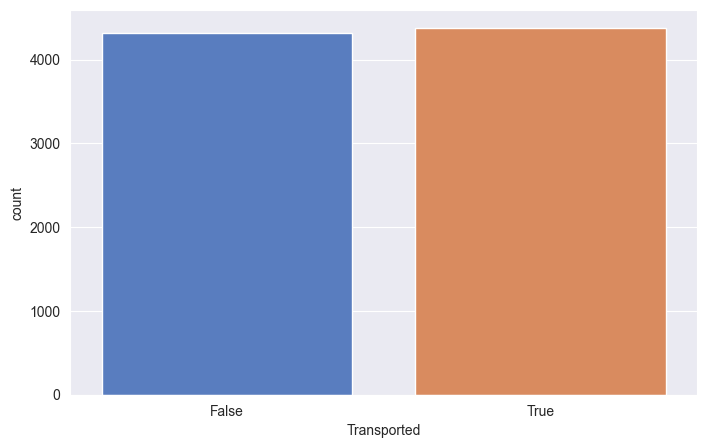

In [9]:
sns.countplot(x=TARGET, data=train_raw)
plt.savefig('figures/eda_1/countplot_response_marginal.png')

### Continuous features

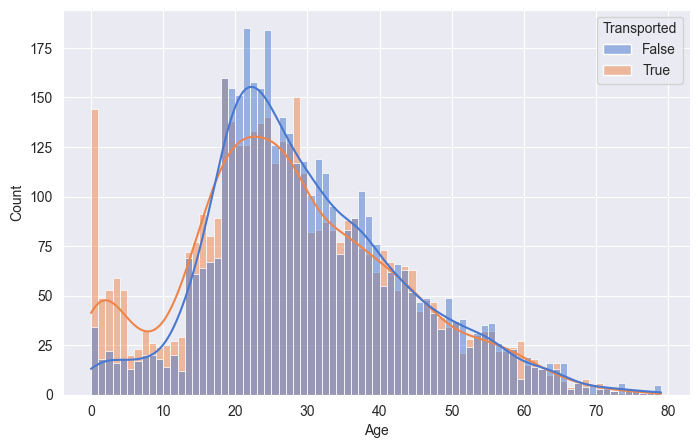

In [10]:
sns.histplot(data=train_raw, x='Age', hue='Transported', binwidth=1, kde=True)
plt.savefig('figures/eda_1/histplot_age_marginal.png')

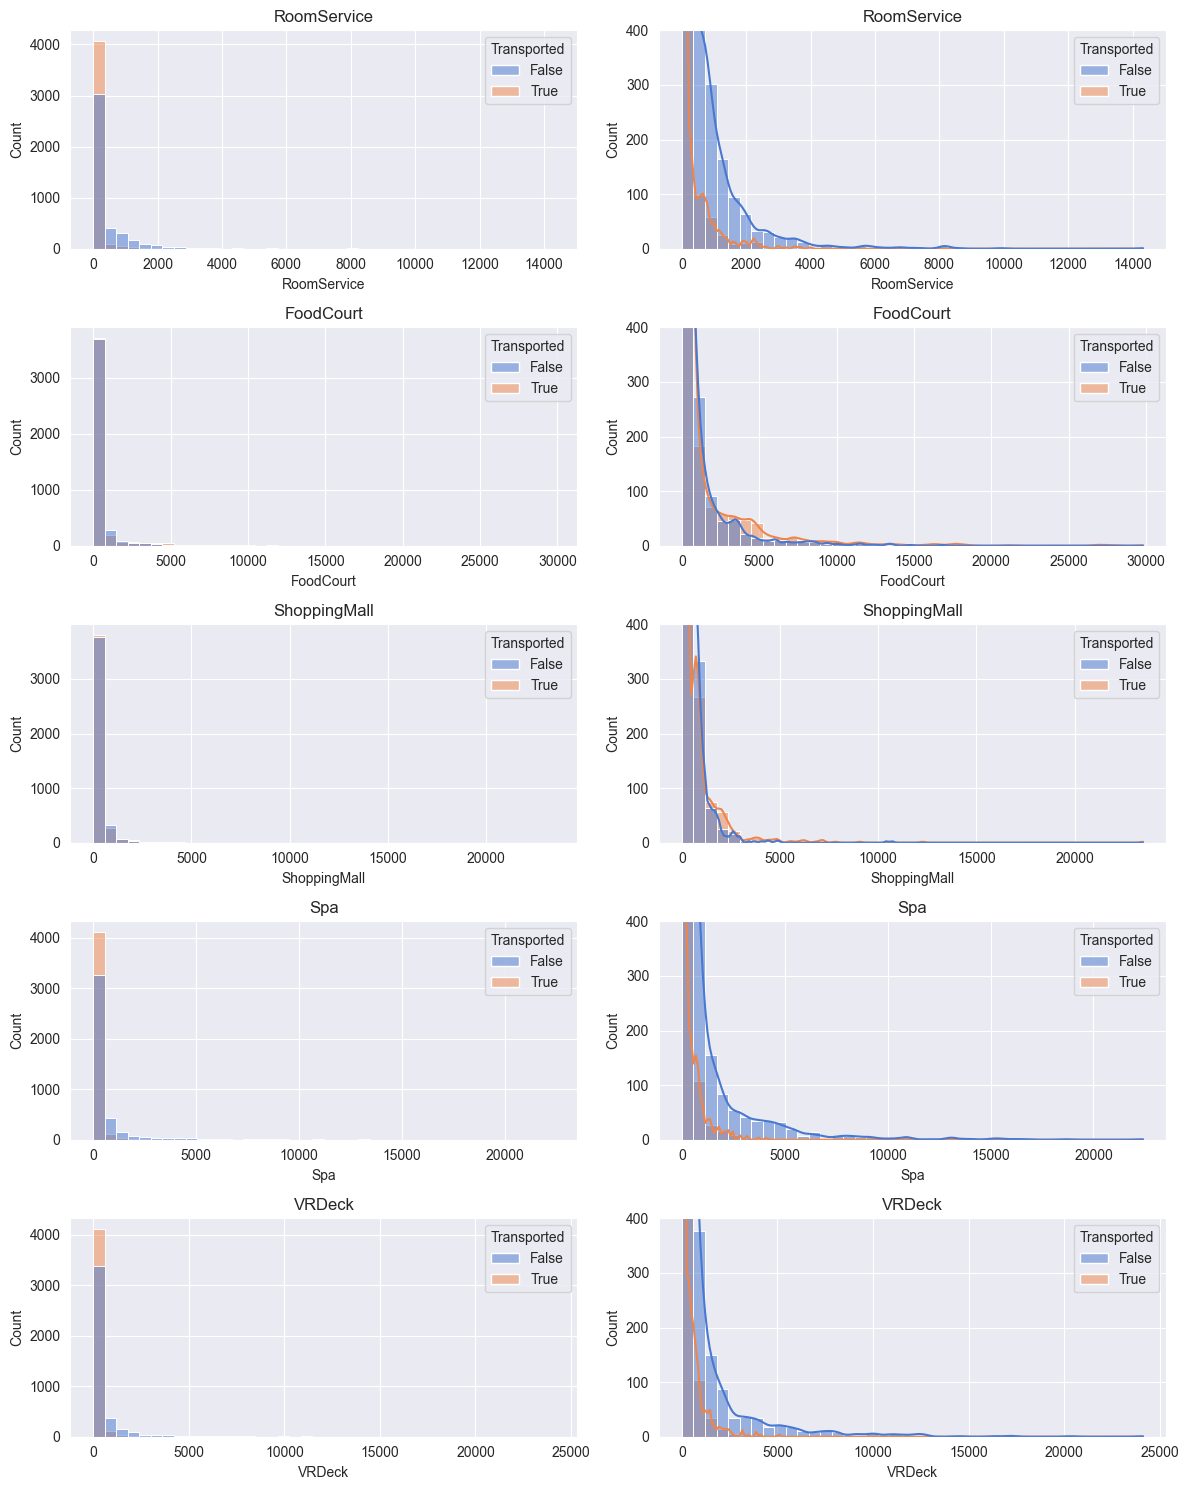

In [11]:
# Expenditure features
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig = plt.figure(figsize=(12, 15))
for i, var_name in enumerate(exp_feats):
    
    # left plot
    ax = fig.add_subplot(5, 2, 2*i+1)
    sns.histplot(data=train_raw, x=var_name, bins=40, kde=False, hue=TARGET, axes=ax)
    ax.set_title(var_name)
    
    # right plot (truncated)
    ax = fig.add_subplot(5, 2, 2*i+2)
    sns.histplot(data=train_raw, x=var_name, bins=40, kde=True, hue=TARGET, axes=ax)
    plt.ylim([0, 400])
    ax.set_title(var_name)

fig.tight_layout()
plt.savefig('figures/eda_1/histplot_exp_feats.png')

### Categorical features

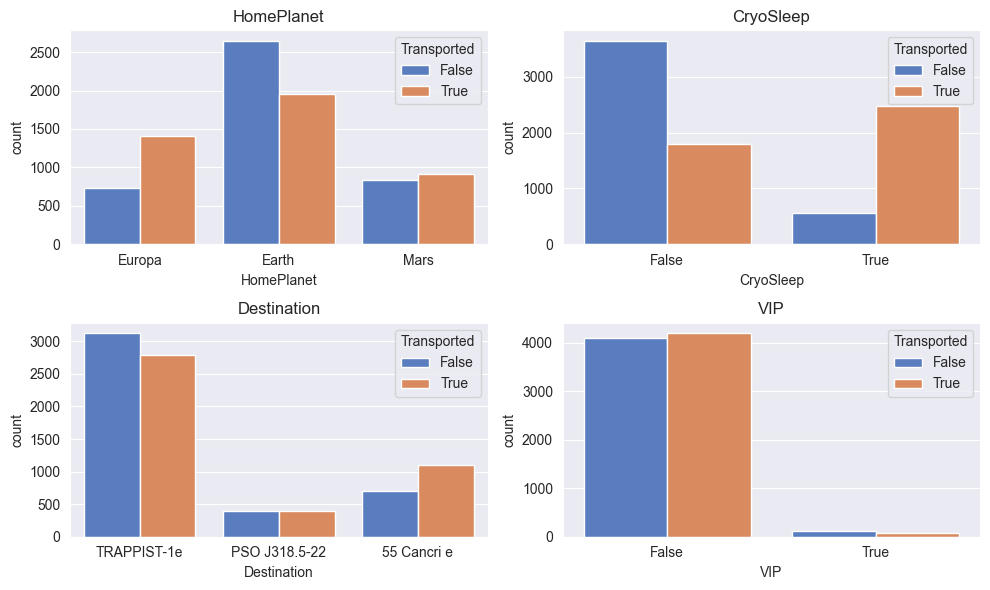

In [12]:
cat_feats = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# plot categorical features
fig = plt.figure(figsize=(10,6))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(2, 2,i+1)
    sns.countplot(data=train_raw, x=var_name, axes=ax, hue=TARGET)
    ax.set_title(var_name)

fig.tight_layout()
plt.savefig('figures/eda_1/countplot_categorical_marginal.png')

In [13]:
# other qualitative features
qual_feats = ['PassengerId', 'Cabin' ,'Name']

# preview qualitative features
train_raw[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


## Feature engineering

In [14]:
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

def preprocess(d):
    
    # feature engineering

    # create feature group
    d['Group'] = d['PassengerId'].str.split('_', expand=True)[0].astype(int)

    # create feature surname
    d['Name'].fillna('Unknown Unknown', inplace=True)
    d['Surname'] = d['Name'].str.split().str[-1]

    # expenditure features
    d['Expenditure'] = d[exp_feats].sum(axis=1)
    d['NoSpending'] = (d['Expenditure']==0).astype(int)

    # split cabin information
    # input nas before splitting
    d['Cabin'].fillna('Z/9999/Z', inplace=True)
    
    d[['CabinDeck', 'CabinNum', 'CabinSide']] = d['Cabin'].str.split('/', expand=True)
    d['CabinNum'] = d['CabinNum'].astype(int)

    # put nas back in
    d.loc[d['CabinDeck']=='Z', 'CabinDeck'] = np.nan
    d.loc[d['CabinNum']==9999, 'CabinNum'] = np.nan
    d.loc[d['CabinSide']=='Z', 'CabinSide'] = np.nan

    # cut Age into bins
    d['Age']=pd.cut(d['Age'], bins=[0, 12, 17, 25, 30, 40, 50, 120]).astype(object)

    return d

# apply feature engineering
train = preprocess(train_raw)
test = preprocess(test_raw)

In [15]:
# additional features GroupCount and FamilySize
tomerge1 = pd.concat([train, test])[['Group', 'PassengerId']].groupby('Group').count().rename(columns={'PassengerId': 'GroupSize'})
tomerge2 = pd.concat([train, test])[['Surname', 'PassengerId']].groupby('Surname').count().rename(columns={'PassengerId': 'FamilySize'})

def preprocess2(d):

    # add GroupSize, Solo and FamilySize
    d = d.merge(tomerge1, on='Group')
    d['Solo'] = (d['GroupSize']==1).astype(bool)
    d = d.merge(tomerge2, on='Surname')

    d.loc[d['Surname']=='Unknown','Surname'] = np.nan
    d.loc[d['FamilySize']>100,'FamilySize'] = np.nan

    # cut Cabin number into bins
    d['CabinGroup']=pd.cut(d['CabinNum'], bins=[-10, 300, 600, 900, 1200, 1500, 1800, 2500]).astype(object)
    
    return d

# apply feature engineering 2
train = preprocess2(train)
test = preprocess2(test)

## Missing values

(taken from [this Kaggle Notebook](https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide#EDA))

In [16]:
# concatenate dataframes
y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()
data=pd.concat([X, test], axis=0).reset_index(drop=True)

In [17]:
# columns with missing values
na_cols = data.columns[data.isna().any()].tolist()

# missing values summary
mv = pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing'] = np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,530,4.09
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


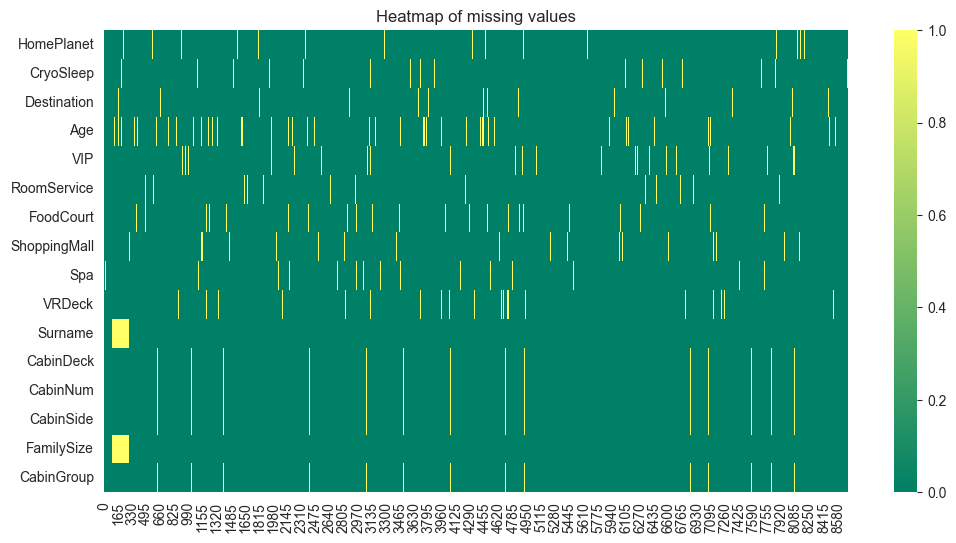

In [18]:
# heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')
plt.savefig('figures/eda_1/heatmap_missingvalues')

### HomePlanet

In [19]:
# joint distribution of Surname and HomePlanet
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
(SHP_gb>0).sum(axis=1).value_counts()

1    2400
dtype: int64

In [20]:
# we can impute missing values for HomePlanet based on Surname
# missing values before
HP_bef = data['HomePlanet'].isna().sum()

# passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index
# fill corresponding missing values
data.loc[SHP_index, 'HomePlanet'] = data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# print number of missing values left
print('HomePlanet missing values before:', HP_bef)
print('HomePlanet missing values after:', data['HomePlanet'].isna().sum())

HomePlanet missing values before: 288
HomePlanet missing values after: 17


In [21]:
# Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


In [22]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 17
#HomePlanet missing values after: 13


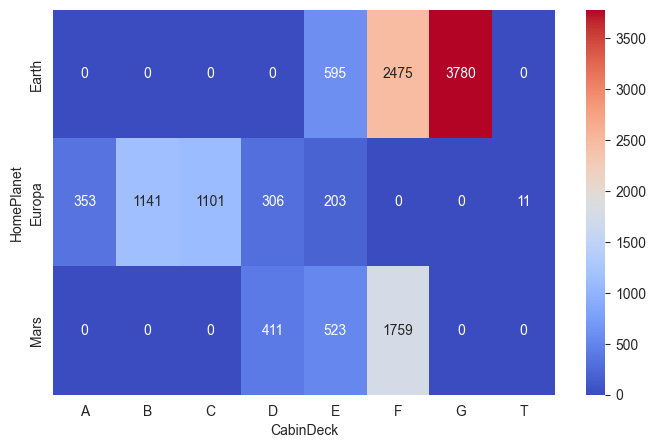

In [23]:
# joint distribution of CabinDeck and HomePlanet
CDHP_gb=data.groupby(['CabinDeck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# heatmap of missing values
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.savefig('figures/eda_1/heatmap_homeplanet_cabindeck.png')

In [24]:
# missing values before
HP_bef = data['HomePlanet'].isna().sum()

# decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['CabinDeck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'

# deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['CabinDeck']=='G'), 'HomePlanet'] = 'Earth'

# print number of missing values left
print('HomePlanet missing values before:', HP_bef)
print('HomePlanet missing values after:', data['HomePlanet'].isna().sum())

HomePlanet missing values before: 13
HomePlanet missing values after: 10


In [25]:
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
149,2443_01,NaN,TRAPPIST-1e
161,3331_01,NaN,TRAPPIST-1e
199,4840_01,NaN,TRAPPIST-1e
229,6108_01,NaN,TRAPPIST-1e
6044,2817_01,NaN,TRAPPIST-1e
8818,8435_01,NaN,TRAPPIST-1e
9409,0616_01,NaN,TRAPPIST-1e
11627,4052_01,NaN,TRAPPIST-1e
12594,7065_01,NaN,TRAPPIST-1e
12595,8775_01,NaN,TRAPPIST-1e


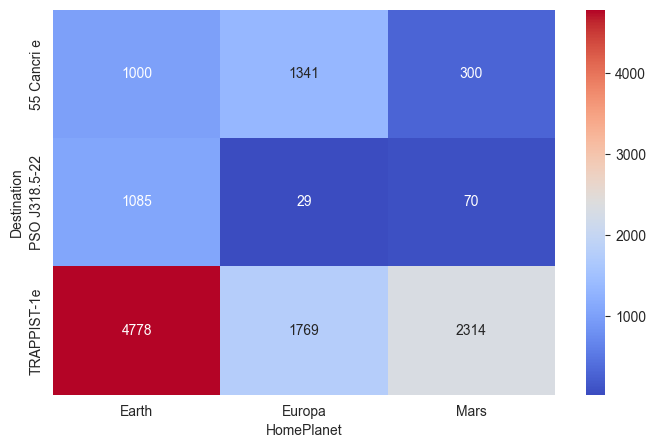

In [26]:
# joint distribution of HomePlanet and Destination
HPD_gb = data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# heatmap of missing values
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.savefig('figures/eda_1/heatmap_homeplanet_destination.png')

In [27]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['CabinDeck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['CabinDeck']=='D'), 'HomePlanet']='Mars'

# print number of missing values left
print('HomePlanet missing values before:', HP_bef)
print('HomePlanet missing values after:', data['HomePlanet'].isna().sum())

HomePlanet missing values before: 10
HomePlanet missing values after: 0


### Destination

In [28]:
# missing values before
D_bef = data['Destination'].isna().sum()

# fill missing Destination values with mode
data.loc[(data['Destination'].isna()), 'Destination'] = 'TRAPPIST-1e'

# print number of missing values left
print('Destination missing values before:', D_bef)
print('Destination missing values after:', data['Destination'].isna().sum())

Destination missing values before: 274
Destination missing values after: 0


### Surname and Group

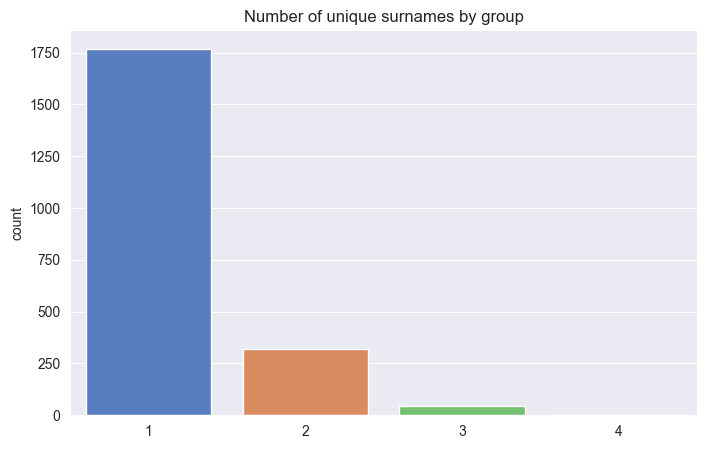

In [29]:
# joint distribution of Group and Surname
GSN_gb = data[data['GroupSize']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

# countplot of unique values
sns.countplot(x=(GSN_gb>0).sum(axis=1))
plt.title('Number of unique surnames by group')
plt.savefig('figures/eda_1/countplot_surname_group')

In [30]:
# surname
# missing values before
SN_bef=data['Surname'].isna().sum()

# passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# fill corresponding missing values
data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# print number of missing values left
print('Surname missing values before:', SN_bef)
print('Surname missing values after:', data['Surname'].isna().sum())

Surname missing values before: 294
Surname missing values after: 155


In [31]:
# replace NaN's with outliers (so we can use map)
data['Surname'].fillna('Unknown', inplace=True)

# update family size feature
tomerge = data[['Surname', 'PassengerId']].groupby('Surname').count().rename(columns={'PassengerId': 'FamilySize'})
data = data.drop('FamilySize', axis=1).merge(tomerge, on='Surname')

# put NaN's back in place of outliers
data.loc[data['Surname']=='Unknown','Surname']=np.nan

# say unknown surname means no family
data.loc[data['FamilySize']>100, 'FamilySize']=0

### CabinSide and Group

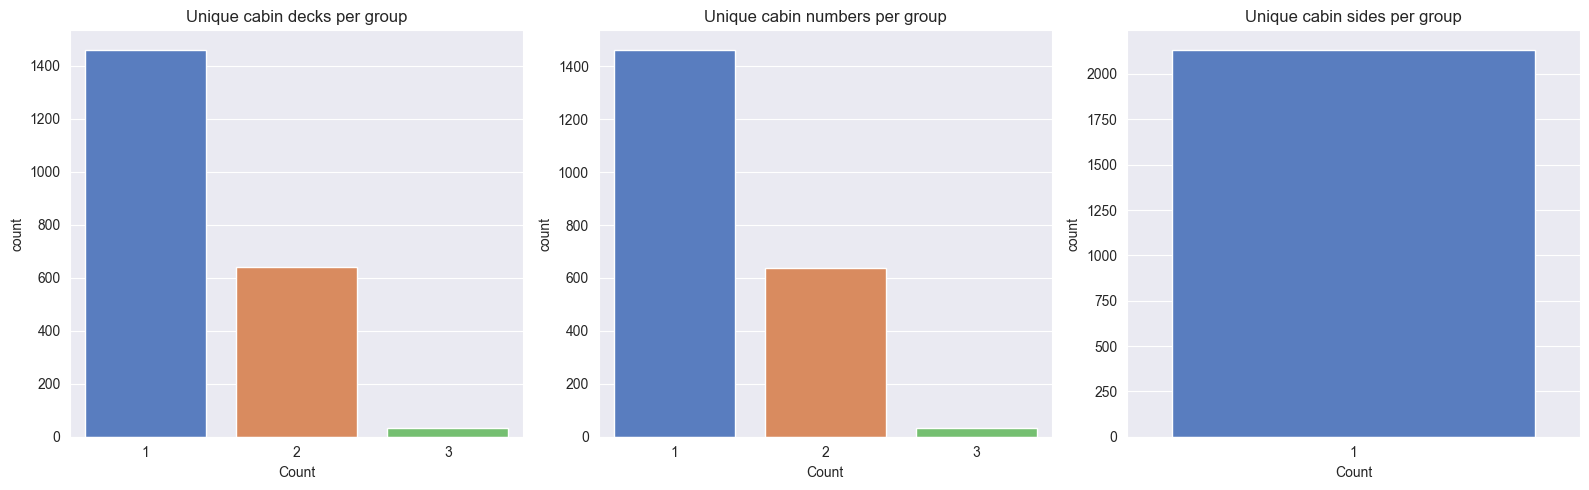

In [32]:
# Joint distribution of Group and Cabin features
GCD_gb = data[data['GroupSize']>1].groupby(['Group','CabinDeck'])['CabinDeck'].size().unstack().fillna(0)
GCN_gb = data[data['GroupSize']>1].groupby(['Group','CabinNum'])['CabinNum'].size().unstack().fillna(0)
GCS_gb = data[data['GroupSize']>1].groupby(['Group','CabinSide'])['CabinSide'].size().unstack().fillna(0)

# Countplots
fig = plt.figure(figsize=(16, 5))
plt.subplot(1,3,1)
a = pd.DataFrame((GCD_gb>0).sum(axis=1), columns=['Count'])
sns.countplot(x=a['Count'])
plt.title('Unique cabin decks per group')

plt.subplot(1,3,2)
a = pd.DataFrame((GCN_gb>0).sum(axis=1), columns=['Count'])
sns.countplot(x=a['Count'])
plt.title('Unique cabin numbers per group')

plt.subplot(1,3,3)
a = pd.DataFrame((GCS_gb>0).sum(axis=1), columns=['Count'])
sns.countplot(x=a['Count'])
plt.title('Unique cabin sides per group')

fig.tight_layout()
plt.savefig('figures/eda_1/countplot_group_cabin_feats.png')

In [33]:
# cabin side (everyone on the same cabin group is also on the same cabin side)
# missing values before
CS_bef = data['CabinSide'].isna().sum()

# Passengers with missing Cabin side and in a group with known Cabin side
GCS_index = data[data['CabinSide'].isna()][(data[data['CabinSide'].isna()]['Group']).isin(GCS_gb.index)].index

# Fill corresponding missing values
data.loc[GCS_index,'CabinSide'] = data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('CabinSide missing values before:', CS_bef)
print('CabinSide missing values after:', data['CabinSide'].isna().sum())

CabinSide missing values before: 299
CabinSide missing values after: 162


### CabinSide and Surname

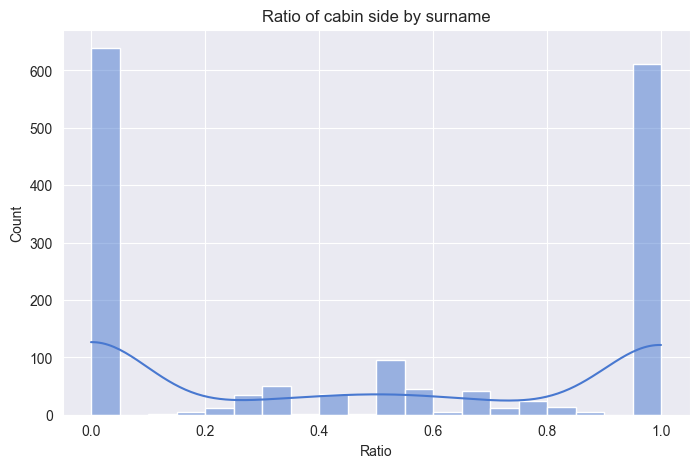

In [34]:
# joint distribution of Surname and Cabin side
SCS_gb=data[data['GroupSize']>1].groupby(['Surname','CabinSide'])['CabinSide'].size().unstack().fillna(0)

# ratio of sides
SCS_gb['Ratio']=SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

# histogram of ratio
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname')
plt.savefig('figures/eda_1/histplot_cabin_surname_ratio.png')

In [35]:
# print proportion
print('Percentage of families all on the same cabin side:', 100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3),'%')

# another view of the same information
SCS_gb.head()

Percentage of families all on the same cabin side: 76.7 %


CabinSide,P,S,Ratio
Surname,,,
Acobson,0.0,3.0,0.0
Acobsond,3.0,0.0,1.0
Adavisons,6.0,0.0,1.0
Admingried,0.0,4.0,0.0
Aginge,3.0,0.0,1.0


In [36]:
# cabin side (families tend to be on the same side)
# missing values before
CS_bef = data['CabinSide'].isna().sum()

# joint distribution of Surname and Cabin side
SCS_gb = data[data['GroupSize']>1].groupby(['Surname','CabinSide'])['CabinSide'].size().unstack().fillna(0)

# passengers with missing Cabin side and in a family with known Cabin side
SCS_index = data[data['CabinSide'].isna()][(data[data['CabinSide'].isna()]['Surname']).isin(SCS_gb.index)].index

# fill corresponding missing values
data.loc[SCS_index,'CabinSide']=data.iloc[SCS_index,:]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

# print number of missing values left
print('Cabin_side missing values before:', CS_bef)
print('Cabin_side missing values after:', data['CabinSide'].isna().sum())

Cabin_side missing values before: 162
Cabin_side missing values after: 66


In [37]:
# replace other missing values with other value since the values are balanced
data['CabinSide'].fillna('missing', inplace=True)
print('Cabin_side missing values:', data['CabinSide'].isna().sum())

Cabin_side missing values: 0


### CabinDeck and Group

In [38]:
# cabin deck
# missing values before
CD_bef = data['CabinDeck'].isna().sum()

# passengers with missing Cabin deck and in a group with known majority Cabin deck
GCD_index = data[data['CabinDeck'].isna()][(data[data['CabinDeck'].isna()]['Group']).isin(GCD_gb.index)].index

# fill corresponding missing values
data.loc[GCD_index,'CabinDeck'] = data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# print number of missing values left
print('CabinDeck missing values before:', CD_bef)
print('CabinDeck missing values after:', data['CabinDeck'].isna().sum())

CabinDeck missing values before: 299
CabinDeck missing values after: 162


### CabinDeck and HomePlanet

In [39]:
# joint distribution
data.groupby(['HomePlanet','Destination','Solo','CabinDeck'])['CabinDeck'].size().unstack().fillna(0)

CabinDeck                           A      B      C      D      E       F  \
HomePlanet Destination   Solo                                               
Earth      55 Cancri e   False    0.0    0.0    0.0    0.0   20.0    90.0   
                         True     0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 False    0.0    0.0    0.0    0.0   18.0    67.0   
                         True     0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   False    0.0    0.0    0.0    0.0  133.0   438.0   
                         True     0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   False   96.0  377.0  313.0   59.0   35.0     0.0   
                         True    67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 False    2.0    5.0   11.0    0.0    0.0     0.0   
                         True     0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   False  152.0  459.0  428.0  120.0   53.0     0.0   
                         True    44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   False    0.0    0.0    0.0   32.0   15.0   104.0   
                         True     0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 False    0.0    0.0    0.0    8.0    9.0    14.0   
                         True     0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   False    0.0    0.0    0.0  168.0  219.0   798.0   
                         True     0.0    0.0    0.0  164.0  263.0   743.0   

CabinDeck                            G    T  
HomePlanet Destination   Solo                
Earth      55 Cancri e   False   272.0  0.0  
                         True    269.0  0.0  
           PSO J318.5-22 False   230.0  0.0  
                         True    466.0  0.0  
           TRAPPIST-1e   False  1075.0  0.0  
                         True   1509.0  0.0  
Europa     55 Cancri e   False     0.0  2.0  
                         True      0.0  0.0  
           PSO J318.5-22 False     0.0  0.0  
                         True      0.0  0.0  
           TRAPPIST-1e   False     0.0  1.0  
                         True      0.0  8.0  
Mars       55 Cancri e   False     0.0  0.0  
                         True      0.0  0.0  
           PSO J318.5-22 False     0.0  0.0  
                         True      0.0  0.0  
           TRAPPIST-1e   False     0.0  0.0  
                         True      0.0  0.0

In [40]:
# missing values before
CD_bef = data['CabinDeck'].isna().sum()

# fill missing values using the mode
na_rows_CD = data.loc[data['CabinDeck'].isna(),'CabinDeck'].index
data.loc[data['CabinDeck'].isna(),'CabinDeck'] = data.groupby(['HomePlanet','Destination','Solo'])['CabinDeck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

# print number of missing values left
print('CabinDeck missing values before:', CD_bef)
print('CabinDeck missing values after:', data['CabinDeck'].isna().sum())

CabinDeck missing values before: 162
CabinDeck missing values after: 0


In [41]:
data[['CabinNum', 'Group']].dtypes

CabinNum    float64
Group         int32
dtype: object

### CabinNum and CabinDeck

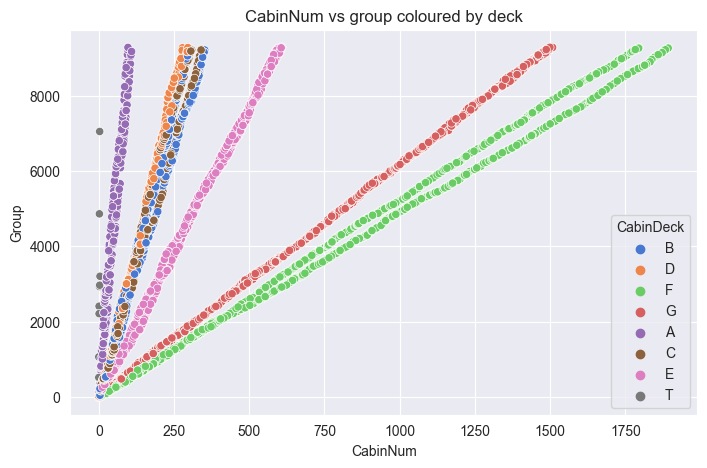

In [42]:
# scatterplot
sns.scatterplot(x=data['CabinNum'], y=data['Group'].astype(int), hue=data['CabinDeck'])#, c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck']), cmap='tab10')
plt.title('CabinNum vs group coloured by deck')
plt.savefig('figures/eda_1/scatter_cabinnum_cabindeck.png')

In [43]:
# missing values before
CN_bef = data['CabinNum'].isna().sum()

# extrapolate linear relationship on a deck by deck basis
from sklearn.linear_model import LinearRegression
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    
    # features and labels
    X_CN = data.loc[~(data['CabinNum'].isna()) & (data['CabinDeck']==deck),'Group']
    y_CN = data.loc[~(data['CabinNum'].isna()) & (data['CabinDeck']==deck),'CabinNum']
    X_test_CN = data.loc[(data['CabinNum'].isna()) & (data['CabinDeck']==deck),'Group']

    # linear regression
    model_CN = LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN = model_CN.predict(X_test_CN.values.reshape(-1, 1))
    
    # fill missing values with predictions
    data.loc[(data['CabinNum'].isna()) & (data['CabinDeck']==deck),'CabinNum'] = preds_CN.astype(int)

# print number of missing values left
print('CabinNum missing values before:', CN_bef)
print('CabinNum missing values after:', data['CabinNum'].isna().sum())

# cut Cabin number into bins
print('CabinGroup missing values before:', data['CabinGroup'].isna().sum())
data['CabinGroup']=pd.cut(data['CabinNum'], bins=[-10, 300, 600, 900, 1200, 1500, 1800, 2500]).astype(object)
print('CabinGroup missing values after:', data['CabinGroup'].isna().sum())

CabinNum missing values before: 299
CabinNum missing values after: 0
CabinGroup missing values before: 299
CabinGroup missing values after: 0


### VIP

In [44]:
data['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [45]:
# missing values before
V_bef = data['VIP'].isna().sum()

# fill missing values with mode
data.loc[data['VIP'].isna(),'VIP'] = False

# print number of missing values left
print('VIP missing values before:', V_bef)
print('VIP missing values after:', data['VIP'].isna().sum())

VIP missing values before: 296
VIP missing values after: 0


### Age

In [46]:
# Joint distribution
data.groupby(['HomePlanet','NoSpending','Solo','CabinDeck'])['Age'].agg(pd.Series.mode).unstack().fillna(0)

CabinDeck                                       A         B         C  \
HomePlanet NoSpending Solo                                              
Earth      0          False                     0         0         0   
                      True                      0         0         0   
           1          False                     0         0         0   
                      True                      0         0         0   
Europa     0          False              (30, 40]  (30, 40]  (30, 40]   
                      True               (30, 40]  (30, 40]  (30, 40]   
           1          False              (30, 40]  (17, 25]  (30, 40]   
                      True   [(25, 30], (30, 40]]  (30, 40]  (30, 40]   
Mars       0          False                     0         0         0   
                      True                      0         0         0   
           1          False                     0         0         0   
                      True                      0         0         0   

CabinDeck                           D         E         F         G         T  
HomePlanet NoSpending Solo                                                     
Earth      0          False         0  (17, 25]  (17, 25]  (17, 25]         0  
                      True          0  (17, 25]  (17, 25]  (17, 25]         0  
           1          False         0   (0, 12]  (12, 17]   (0, 12]         0  
                      True          0  (17, 25]  (17, 25]  (17, 25]         0  
Europa     0          False  (30, 40]  (30, 40]         0         0  (40, 50]  
                      True   (30, 40]  (30, 40]         0         0  (30, 40]  
           1          False  (17, 25]  (30, 40]         0         0         0  
                      True   (25, 30]  (30, 40]         0         0         0  
Mars       0          False  (17, 25]  (17, 25]  (17, 25]         0         0  
                      True   (30, 40]  (17, 25]  (30, 40]         0         0  
           1          False  (30, 40]  (17, 25]   (0, 12]         0         0  
                      True   (17, 25]  (17, 25]  (17, 25]         0         0

In [47]:
# missing values before
A_bef = data['Age'].isna().sum()

# fill missing values using the median
na_rows_A = data.loc[data['Age'].isna(),'Age'].index
data.loc[data['Age'].isna(),'Age'] = data.groupby(['HomePlanet','NoSpending','Solo','CabinDeck'])['Age'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_A]

# print number of missing values left
print('Age missing values before:', A_bef)
print('Age missing values after:', data['Age'].isna().sum())

Age missing values before: 530
Age missing values after: 0


### CryoSleep

In [48]:
# joint distribution
data.groupby(['NoSpending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
NoSpending,,
0,7339.0,0.0
1,740.0,4581.0


In [49]:
# missing values before
CSL_bef=data['CryoSleep'].isna().sum()

# fill missing values using the mode
na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
data.loc[data['CryoSleep'].isna(),'CryoSleep'] = data.groupby(['NoSpending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

# print number of missing values left
print('CryoSleep missing values before:', CSL_bef)
print('CryoSleep missing values after:', data['CryoSleep'].isna().sum())

CryoSleep missing values before: 310
CryoSleep missing values after: 0


### Expenditures and CryoSleep

In [50]:
# missing values before
E_bef = data[exp_feats].isna().sum().sum()

# cryoSleep has no expenditure
for col in exp_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col] = 0

# print number of missing values left
print('Expenditure missing values before:', E_bef)
print('Expenditure missing values after:', data[exp_feats].isna().sum().sum())

Expenditure missing values before: 1410
Expenditure missing values after: 866


### Expenditures and others

In [51]:
# joint distribution
data.groupby(['HomePlanet','Solo', 'Destination'])['Expenditure'].mean().unstack().fillna(0)

Destination       55 Cancri e  PSO J318.5-22  TRAPPIST-1e
HomePlanet Solo                                          
Earth      False   388.243455     415.107937   550.405225
           True    740.144013     472.966234   837.280718
Europa     False  3403.696145    7228.722222  3109.126958
           True   3953.490196    1690.545455  3558.027687
Mars       False   917.721854     987.741935  1007.165965
           True   1393.651007    1061.461538  1081.112782

In [52]:
# missing values before
E_bef = data[exp_feats].isna().sum().sum()

# fill remaining missing values using the median
for col in exp_feats:
    na_rows = data.loc[data[col].isna(), col].index
    data.loc[data[col].isna(),col] = data.groupby(['HomePlanet','Solo','Destination'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]
    
# print number of missing values left
print('Expenditure missing values before:', E_bef)
print('Expenditure missing values after:', data[exp_feats].isna().sum().sum())

# update Expenditure and NoSpending
data['Expenditure'] = data[exp_feats].sum(axis=1)
data['NoSpending'] = (data['Expenditure']==0).astype(bool)

Expenditure missing values before: 866
Expenditure missing values after: 0


In [53]:
numerical = data.select_dtypes(include=np.number).columns
categorical = data.select_dtypes(exclude=np.number).columns

data.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name              0
Group             0
Surname         155
Expenditure       0
NoSpending        0
CabinDeck         0
CabinNum          0
CabinSide         0
GroupSize         0
Solo              0
CabinGroup        0
FamilySize        0
dtype: int64

## Preprocessing

In [54]:
# train and test
train = data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
train[TARGET] = y.values
test = data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

In [55]:
# drop unwanted features
train.drop(columns=['PassengerId', 'Group', 'Cabin', 'CabinNum', 'Surname', 'Name'], inplace=True)
test.drop(columns=['PassengerId', 'Group', 'Cabin', 'CabinNum', 'Surname', 'Name'], inplace=True)

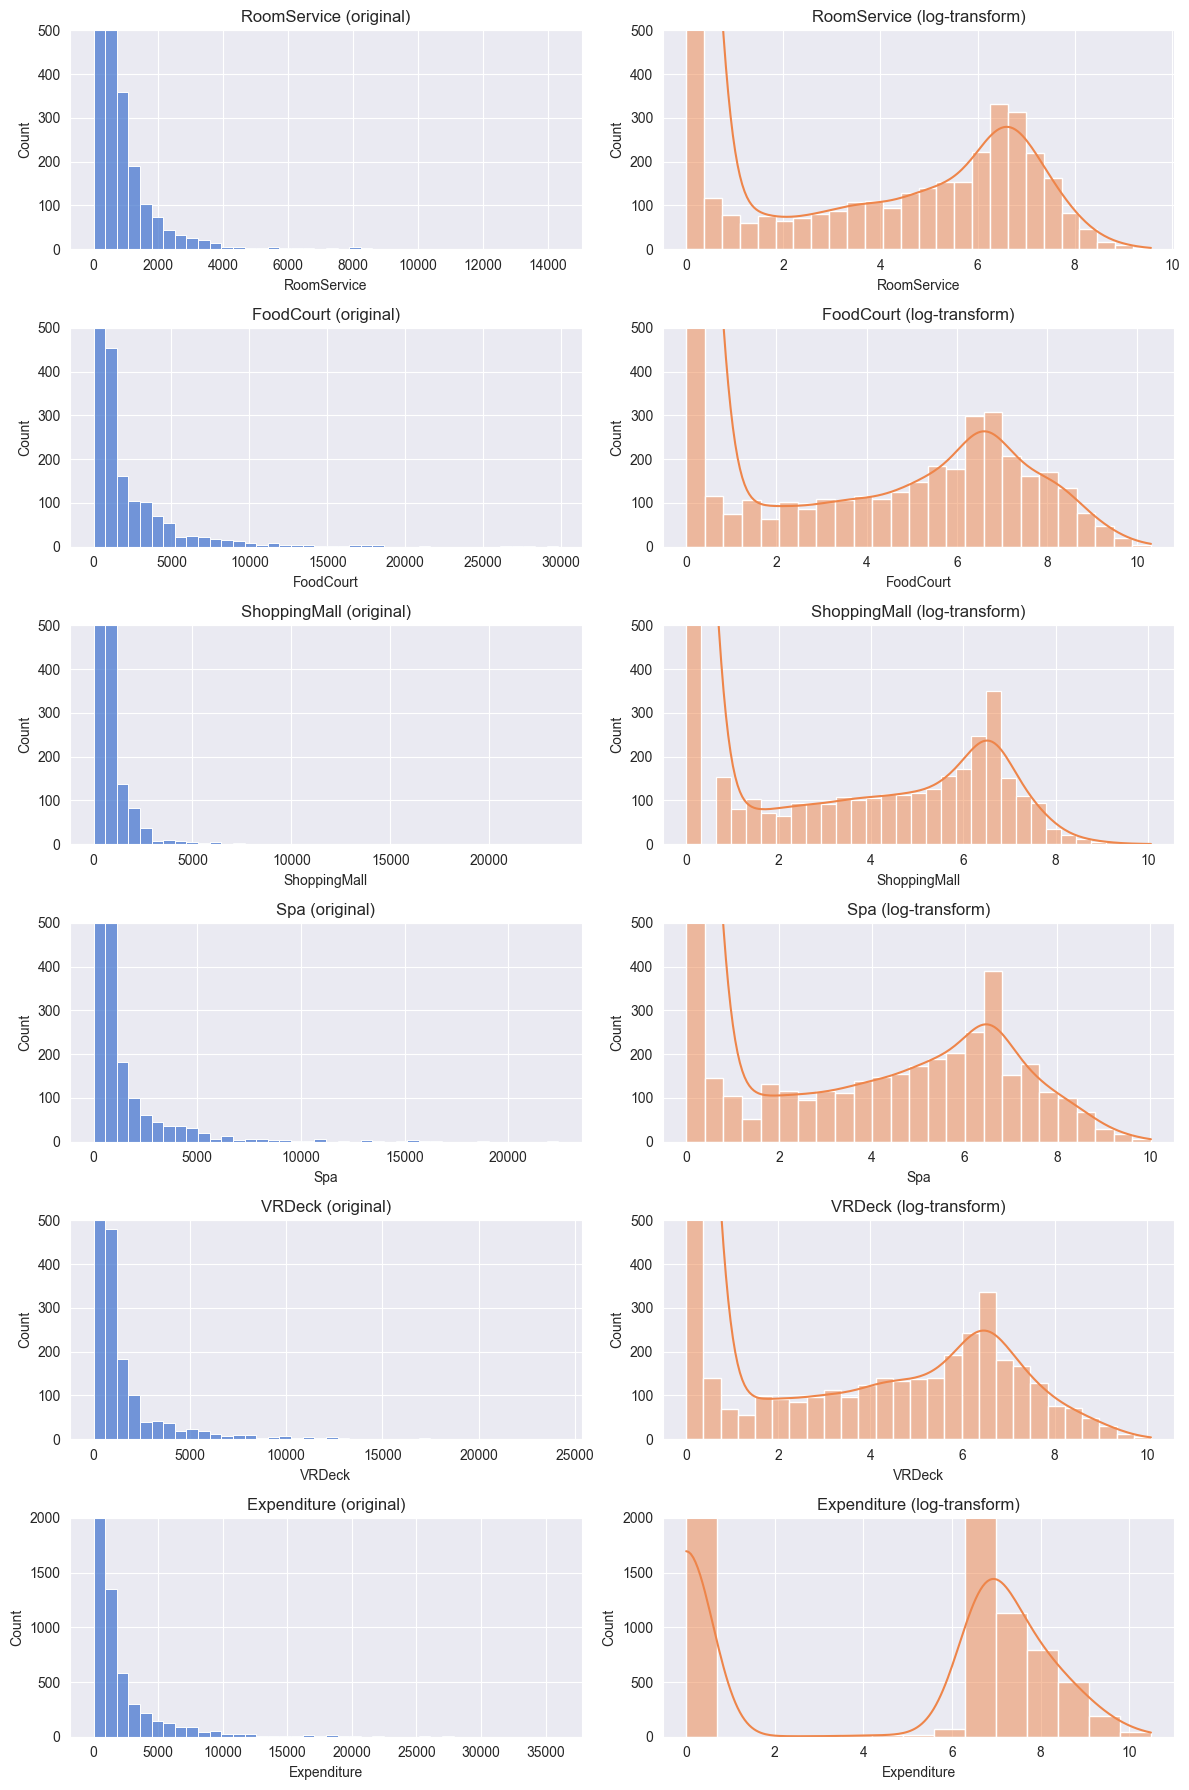

In [56]:
# plot log transform results
exp_feats = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']
fig = plt.figure(figsize=(12, 18))
for i, col in enumerate(exp_feats):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], bins=40, kde=False)
    plt.title(f'{col} (original)')
    if i==5:
        plt.ylim([0, 2000])
    else:
        plt.ylim([0, 500])
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1', kde=True)
    plt.title(f'{col} (log-transform)')
    if i==5:
        plt.ylim([0, 2000])
    else:
        plt.ylim([0, 500])
    
fig.tight_layout()
plt.savefig('figures/eda_1/histplot_exp_feats_log.png')

In [57]:
# apply log transform
for col in exp_feats:
    train[col] = np.log(1+train[col])
    test[col] = np.log(1+test[col])

In [58]:
# last check for missing values and duplicates
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

## Recap and save

In [59]:
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col not in [TARGET]]

numerical = train[FEATURES].select_dtypes(include=np.number).columns
categorical = train[FEATURES].select_dtypes(exclude=np.number).columns

print(f'Target: {TARGET}')
print(f'Features:\n\tnumerical: {numerical.to_list()}\n\tcategorical:{categorical.to_list()}')
print(f'Shapes:\n\ttrain: {train.shape}\n\ttest: {test.shape}')

train.head()

Target: Transported
Features:
	numerical: ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure', 'GroupSize', 'FamilySize']
	categorical:['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'NoSpending', 'CabinDeck', 'CabinSide', 'Solo', 'CabinGroup']
Shapes:
	train: (8693, 19)
	test: (4277, 18)


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenditure,NoSpending,CabinDeck,CabinSide,GroupSize,Solo,CabinGroup,FamilySize,Transported
0,Europa,False,TRAPPIST-1e,"(30, 40]",False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True,B,P,1,True,"(-10, 300]",4,0
4,Earth,False,TRAPPIST-1e,"(17, 25]",False,4.700480,2.302585,3.258097,6.309918,3.806662,6.602588,False,F,S,1,True,"(-10, 300]",4,1
5,Earth,False,TRAPPIST-1e,"(17, 25]",False,0.000000,3.218876,6.423247,2.302585,0.000000,6.475433,False,F,P,1,True,"(-10, 300]",4,1
6,Earth,False,TRAPPIST-1e,"(30, 40]",False,0.693147,0.000000,2.079442,0.000000,5.961005,5.981414,False,G,P,1,True,"(900, 1200]",4,1
7,Earth,False,TRAPPIST-1e,"(17, 25]",False,0.000000,2.890372,1.791759,0.000000,6.569481,6.599870,False,F,S,1,True,"(1500, 1800]",4,1


In [60]:
# save preprocessed data
os.makedirs('../data/final', exist_ok=True)
train.to_csv('../data/final/train.csv', index=False)
test.to_csv('../data/final/test.csv', index=False)